# CNN-TL |  Using TRANSFER LEARNING

In [1]:
# Imports
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from keras import datasets, layers, models
from keras.callbacks import EarlyStopping  # Keras callbacks
from keras.layers import Dense  # Keras layers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import load_model

# Disable warns
pd.options.mode.chained_assignment = None  # default='warn'

# Set seaborn theme to the plots
sns.set()

2025-03-19 22:26:29.441979: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-19 22:26:29.449114: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-19 22:26:29.457701: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-19 22:26:29.460144: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-19 22:26:29.467020: I tensorflow/core/platform/cpu_feature_guar

## UNSW-NB15-Train-Basic for training and UNSW-NB15-Test+ for validation

In [2]:
# Load UNSW-NB15-Train-Basic
data = pd.read_csv('../datasets/UNSW-NB15-Train-Basic.csv', low_memory=False)

# Select the 'proto' and 'state' values that I want
data = data.loc[(data['proto'] == 'tcp') | (data['proto'] =='udp') | (data['proto'] =='icmp') | (data['proto'] =='arp') | (data['proto'] =='ipv6-icmp') | (data['proto'] =='igmp') | (data['proto'] =='rarp'), :]
data = data.loc[(data['state'] == 'RST') | (data['state'] =='REQ') | (data['state'] =='INT') | (data['state'] =='FIN') | (data['state'] =='CON') | (data['state'] =='ECO') | (data['state'] =='ACC') | (data['state'] =='PAR'), :]

# Extracting dataset labels
data_labels=data[['label']]

# Drop the invalid features and select interested data features
data_features=data[['proto','srcip','sport','dstip','dsport','spkts','dpkts','sbytes','dbytes','state','stime','ltime','dur']]

In [3]:
"""PREPROCESSING"""

# Preprocess IP and ports features
# IP Source Address
data_features['srcip'] = data_features['srcip'].apply(lambda x: x.split(".")[-1])
data_features['srcip'] = data_features['srcip'].apply(lambda x: x.split(":")[-1])
data_features['srcip'] = data_features['srcip'].apply(lambda x: int(x, 16))

# IP Destination Address
data_features['dstip'] = data_features['dstip'].apply(lambda x: x.split(".")[-1])
data_features['dstip'] = data_features['dstip'].apply(lambda x: x.split(":")[-1])
data_features['dstip'] = data_features['dstip'].apply(lambda x: int(x, 16))

# Ports
data_features['sport'] = data_features['sport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)
data_features['dsport'] = data_features['dsport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)

# Convert all ports with 0 decimal, and HEX to DEC
data_features['sport'] = data_features['sport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['sport'] = data_features['sport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

data_features['dsport'] = data_features['dsport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['dsport'] = data_features['dsport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

# Convert field to int format
data_features['srcip'] = data_features['srcip'].astype(int)
data_features['sport'] = data_features['sport'].astype(int)
data_features['dstip'] = data_features['dstip'].astype(int)
data_features['dsport'] = data_features['dsport'].astype(int)

# Convert some fields to logarithmic
log1p_col = ['dur', 'sbytes', 'dbytes', 'spkts']

for col in log1p_col:
    data_features[col] = data_features[col].apply(np.log1p)
    
# Create a complementary field of attack & Transform to One hot encoding - LABELS
normal=data_labels['label']
normal=normal.replace(1,2)
normal=normal.replace(0,1)
normal=normal.replace(2,0)

# Insert the new column in data labels
data_labels.insert(1, 'normal', normal)
data_labels = pd.get_dummies(data_labels)

# Transform to One hot encoding - FEATURES
data_features=pd.get_dummies(data_features)

# Normalize all data features
data_features = StandardScaler().fit_transform(data_features)

#Add dimension to data features
data_features = np.expand_dims(data_features, axis=2)
data_features = np.expand_dims(data_features, axis=3)

x_train, y_train=data_features, data_labels

In [4]:
x_train.shape

(410556, 24, 1, 1)

In [5]:
# Load UNSW-NB15-Test+
data = pd.read_csv('../datasets/UNSW-NB15-Test+.csv', low_memory=False)

# Select the 'proto' and 'state' values that I want
data = data.loc[(data['proto'] == 'tcp') | (data['proto'] =='udp') | (data['proto'] =='icmp') | (data['proto'] =='arp') | (data['proto'] =='ipv6-icmp') | (data['proto'] =='igmp') | (data['proto'] =='rarp'), :]
data = data.loc[(data['state'] == 'RST') | (data['state'] =='REQ') | (data['state'] =='INT') | (data['state'] =='FIN') | (data['state'] =='CON') | (data['state'] =='ECO') | (data['state'] =='ACC') | (data['state'] =='PAR'), :]

# Extracting dataset labels
data_labels=data[['label']]

#Extracting dataset features
data_features=data[['proto','srcip','sport','dstip','dsport','spkts','dpkts','sbytes','dbytes','state','stime','ltime','dur']]

In [6]:
"""PREPROCESSING"""

# Preprocess IP and ports features
# IP Source Address
data_features['srcip'] = data_features['srcip'].apply(lambda x: x.split(".")[-1])
data_features['srcip'] = data_features['srcip'].apply(lambda x: x.split(":")[-1])
data_features['srcip'] = data_features['srcip'].apply(lambda x: int(x, 16))

# IP Destination Address
data_features['dstip'] = data_features['dstip'].apply(lambda x: x.split(".")[-1])
data_features['dstip'] = data_features['dstip'].apply(lambda x: x.split(":")[-1])
data_features['dstip'] = data_features['dstip'].apply(lambda x: int(x, 16))

# Ports
data_features['sport'] = data_features['sport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)
data_features['dsport'] = data_features['dsport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)

# Convert all ports with 0 decimal, and HEX to DEC
data_features['sport'] = data_features['sport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['sport'] = data_features['sport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

data_features['dsport'] = data_features['dsport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['dsport'] = data_features['dsport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

# Convert field to int format
data_features['srcip'] = data_features['srcip'].astype(int)
data_features['sport'] = data_features['sport'].astype(int)
data_features['dstip'] = data_features['dstip'].astype(int)
data_features['dsport'] = data_features['dsport'].astype(int)

# Convert some fields to logarithmic
log1p_col = ['dur', 'sbytes', 'dbytes', 'spkts']

for col in log1p_col:
    data_features[col] = data_features[col].apply(np.log1p)
    
# Create a complementary field of attack & Transform to One hot encoding - LABELS
normal=data_labels['label']
normal=normal.replace(1,2)
normal=normal.replace(0,1)
normal=normal.replace(2,0)

# Insert the new column in data labels
data_labels.insert(1, 'normal', normal)
data_labels = pd.get_dummies(data_labels)

# Transform to One hot encoding - FEATURES
data_features=pd.get_dummies(data_features)

# Generate 2 new columns to fit with training
auxCol=data_features['sbytes']
auxCol=0
data_features.insert(13, 'proto_igmp', auxCol, True)
data_features.insert(21, 'state_PAR', auxCol, True)

# Normalize all data features
data_features = StandardScaler().fit_transform(data_features)

#Add dimension to data features
data_features = np.expand_dims(data_features, axis=2)
data_features = np.expand_dims(data_features, axis=3)

x_test, y_test=data_features, data_labels

In [7]:
x_test.shape

(55052, 24, 1, 1)

## Load Pretrained Model
Loading pretrained model from BoT-IoT and freeze convolutional base

In [9]:
# Load model of BoT-IoT Dataset
pre_trained_model = load_model('../models/tmp/BoT-IoT_CNN_Detection.keras')

I0000 00:00:1742401694.045747 2752734 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1742401694.045882 2752734 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1742401694.071330 2752734 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1742401694.071525 2752734 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [10]:
# Setting all layers to non trainable
pre_trained_model.trainable=False

In [11]:
# Removing the last 3 layers to get only the convolutional base
pre_trained_model.pop()
pre_trained_model.pop()
pre_trained_model.pop()

<Flatten name=flatten, built=True>

In [12]:
pre_trained_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 24, 1, 32)      │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 1, 64)      │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 1, 64)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,429,326 (5.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,896 (81.62 KB)

 Optimizer params: 1,408,430 (5.37 MB)

## Transfer Learning
Creating the new model and training

In [13]:
# New model building
modelFE = models.Sequential()
modelFE.add(pre_trained_model)

modelFE.add(layers.Flatten())
modelFE.add(Dense(448, activation='relu'))
modelFE.add(layers.Dropout(0.4))
modelFE.add(Dense(224, activation='relu'))
modelFE.add(layers.Dropout(0.3))
modelFE.add(Dense(112, activation='relu'))
modelFE.add(layers.Dropout(0.3))
modelFE.add(Dense(2, activation='softmax'))

In [14]:
# Model summary
modelFE.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 24, 1, 64)      │        20,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 448)            │       688,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 448)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 224)            │       100,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 224)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 112)            │        25,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 112)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           226 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 835,474 (3.19 MB)

 Trainable params: 814,578 (3.11 MB)

 Non-trainable params: 20,896 (81.62 KB)

In [16]:
# Early Stopping
with tf.device('/GPU:0'):  # Use GPU 0    

    filepath = '../models/tmp/TransferLearning_Detection.keras' # define where the model is saved
    callbacks = [
            keras.callbacks.EarlyStopping(
                monitor = 'val_loss', # Use accuracy to monitor the model
                patience = 2 # Stop after 5 steps with lower accuracy
            ),
            keras.callbacks.ModelCheckpoint(
                filepath = filepath, # file where the checkpoint is saved
                monitor = 'val_loss', # Don't overwrite the saved model unless val_loss is worse
                save_best_only = True)]# Only save model if it is the best

In [17]:
#Configure model training
with tf.device('/GPU:0'):  # Use GPU 0    

    modelFE.compile(optimizer=tf.keras.optimizers.Adam(2e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    history = modelFE.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=15,  batch_size=2048, callbacks=callbacks)

Epoch 1/15


I0000 00:00:1742401808.561576 2969678 service.cc:146] XLA service 0x76af40004610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742401808.561597 2969678 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
I0000 00:00:1742401808.561599 2969678 service.cc:154]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-03-19 22:30:08.577070: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-19 22:30:08.651514: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101
2025-03-19 22:30:09.207142: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1696', 2392 bytes spill stores, 2268 bytes spill loads

2025-03-19 22:30:09.238895:

110/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7556 - loss: 0.6275

I0000 00:00:1742401810.262579 2969678 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


186/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7864 - loss: 0.5866

2025-03-19 22:30:10.930770: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1696', 4 bytes spill stores, 4 bytes spill loads

2025-03-19 22:30:11.255066: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1696', 12 bytes spill stores, 12 bytes spill loads



201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7909 - loss: 0.5785

2025-03-19 22:30:13.024513: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_83', 24 bytes spill stores, 24 bytes spill loads

2025-03-19 22:30:13.057616: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_83', 320 bytes spill stores, 320 bytes spill loads

2025-03-19 22:30:14.049350: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_83', 80 bytes spill stores, 80 bytes spill loads

2025-03-19 22:30:14.357009: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_83', 120 bytes spill stores, 120 bytes spill loads

2025-03-19 22:30:14.369031: I external/local_xla/xla/stream_exec

201/201 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.7911 - loss: 0.5779 - val_accuracy: 0.8681 - val_loss: 0.3522
Epoch 2/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9496 - loss: 0.1908 - val_accuracy: 0.9874 - val_loss: 0.0827
Epoch 3/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9862 - loss: 0.0677 - val_accuracy: 0.9887 - val_loss: 0.0572
Epoch 4/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9893 - loss: 0.0474 - val_accuracy: 0.9892 - val_loss: 0.0520
Epoch 5/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9903 - loss: 0.0422 - val_accuracy: 0.9906 - val_loss: 0.0497
Epoch 6/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9910 - loss: 0.0387 - val_accuracy: 0.9904 - val_loss: 0.0489
Epoch 7/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9918 - loss: 0.0352 - val_accuracy: 0.9904 - val_loss: 0.0500
Epoch 8/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9918 - loss: 0.0340 - val_accuracy: 0.9904 - val

## Loading Best model from Transfer Learning
Load and validate the final transfer learning model

In [18]:
# Load Transfer Learning model
modelFE = load_model('../models/tmp/TransferLearning_Detection.keras')

/home/deeplearning01/anaconda3/envs/TL_IDS/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [19]:
#Evaluate the model
results = modelFE.evaluate(x_test, y_test, verbose=0)
print("test loss, test acc:", results)

test loss, test acc: [0.04885903000831604, 0.9903908967971802]


1721/1721 ━━━━━━━━━━━━━━━━━━━━ 2s 626us/step


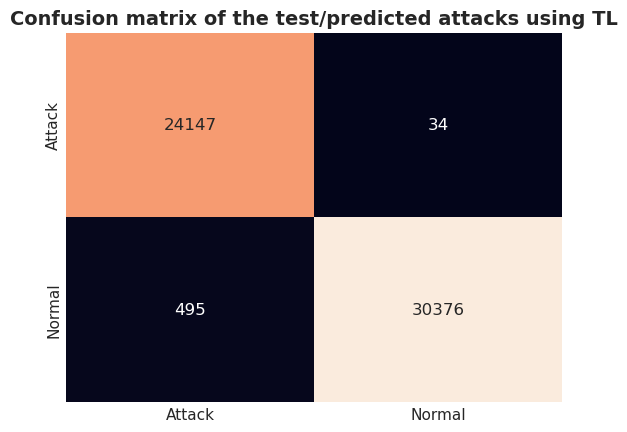

In [20]:
with tf.device('/GPU:0'):  # Use GPU 0    
    # Prediction
    predicted = modelFE.predict(x_test)

    # Confusion matrix
    y_class = np.argmax(predicted, axis = 1)
    y_test1=y_test
    y_test1=y_test1.to_numpy()
    y_check = np.argmax(y_test1, axis = 1) 

    cmatrix = confusion_matrix(y_check, y_class)

    cmatrix_df = pd.DataFrame(cmatrix, index = ['Attack', 'Normal'], columns = ['Attack', 'Normal'])
    plt.title('Confusion matrix of the test/predicted attacks using TL', weight='bold', fontsize=14)
    plt.tick_params(length=0)
    plt.xlabel('Attacks')
    plt.ylabel('Predicted Attacks')
    sns.heatmap(cmatrix_df, annot=True, fmt="d", cbar=False)
    plt.show()

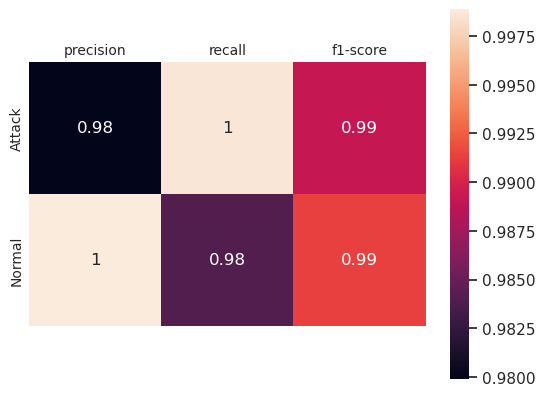

In [21]:
# Precision, Recall & F1-Score
class_rep = classification_report(y_check, y_class, target_names = ['Attack', 'Normal'], output_dict=True)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
plt.tick_params(length=0)
sns.heatmap(pd.DataFrame(class_rep).iloc[:-1, :-3].T, square=True, cbar=True, annot=True)
plt.show()

In [22]:
class_rep

{'Attack': {'precision': 0.9799123447772097,
  'recall': 0.998593937388859,
  'f1-score': 0.9891649427523913,
  'support': 24181.0},
 'Normal': {'precision': 0.99888194672805,
  'recall': 0.9839655339963073,
  'f1-score': 0.9913676343401707,
  'support': 30871.0},
 'accuracy': 0.9903909031461164,
 'macro avg': {'precision': 0.9893971457526298,
  'recall': 0.9912797356925831,
  'f1-score': 0.990266288546281,
  'support': 55052.0},
 'weighted avg': {'precision': 0.9905497527156023,
  'recall': 0.9903909031461164,
  'f1-score': 0.9904001257068041,
  'support': 55052.0}}

## Analysing Attack Detection

### Code

In [23]:
predicted

array([[9.7760701e-01, 2.2392964e-02],
       [9.7791791e-01, 2.2082150e-02],
       [9.6426404e-01, 3.5736017e-02],
       ...,
       [1.3621351e-04, 9.9986374e-01],
       [1.0587720e-04, 9.9989414e-01],
       [3.9674426e-04, 9.9960333e-01]], dtype=float32)

In [24]:
df = pd.DataFrame(predicted)
df.index = data.index

In [25]:
df['attack']=data['label']
df['category']=data['attack_cat']
df['normal']=data_labels['normal']

In [26]:
df.columns = ['pred_attack', 'pred_normal', 'attack', 'category', 'normal']

In [27]:
dff=df
df=pd.get_dummies(df)
df=round(df)

In [28]:
analysis=df.loc[df['category_analysis'] == 1]
analysis=analysis[['pred_attack', 'pred_normal', 'attack', 'normal']]
analysis_pred=analysis[['pred_attack','pred_normal']]
analysis_check=analysis[['attack','normal']]

backdoor=df.loc[df['category_backdoor'] == 1]
backdoor=backdoor[['pred_attack', 'pred_normal', 'attack', 'normal']]
backdoor_pred=backdoor[['pred_attack','pred_normal']]
backdoor_check=backdoor[['attack','normal']]

fuzzers=df.loc[df['category_fuzzers'] == 1]
fuzzers=fuzzers[['pred_attack', 'pred_normal', 'attack', 'normal']]
fuzzers_pred=fuzzers[['pred_attack','pred_normal']]
fuzzers_check=fuzzers[['attack','normal']]

normal=df.loc[df['category_normal'] == 1]
normal=normal[['pred_attack', 'pred_normal', 'attack', 'normal']]
normal_pred=normal[['pred_attack','pred_normal']]
normal_check=normal[['attack','normal']]

shellcode=df.loc[df['category_shellcode'] == 1]
shellcode=shellcode[['pred_attack', 'pred_normal', 'attack', 'normal']]
shellcode_pred=shellcode[['pred_attack','pred_normal']]
shellcode_check=shellcode[['attack','normal']]

worms=df.loc[df['category_worms'] == 1]
worms=worms[['pred_attack', 'pred_normal', 'attack', 'normal']]
worms_pred=worms[['pred_attack','pred_normal']]
worms_check=worms[['attack','normal']]

In [29]:
#Correctly detected
countdata=pd.DataFrame()
normal_c = normal['pred_normal'] * normal['normal']
analysis_c = analysis['pred_attack'] * analysis['attack']
backdoor_c = backdoor['pred_attack'] * backdoor['attack']
fuzzers_c = fuzzers['pred_attack'] * fuzzers['attack']
shellcode_c = shellcode['pred_attack'] * shellcode['attack']
worms_c = worms['pred_attack'] * worms['attack']


In [30]:
# Count 0 and 1
normal_c0 = (normal_c == 0).sum()
normal_c1 = len(normal) - normal_c0

analysis_c0 = (analysis_c == 0).sum()
analysis_c1 = len(analysis) - analysis_c0

backdoor_c0 = (backdoor_c == 0).sum()
backdoor_c1 = len(backdoor) - backdoor_c0

fuzzers_c0 = (fuzzers_c == 0).sum()
fuzzers_c1 = len(fuzzers) - fuzzers_c0

shellcode_c0 = (shellcode_c == 0).sum()
shellcode_c1 = len(shellcode) - shellcode_c0

worms_c0 = (worms_c == 0).sum()
worms_c1 = len(worms) - worms_c0

In [31]:
normal_0, normal_1 = normal_c0*100 / len(normal), normal_c1*100 / len(normal)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(normal_0, normal_1))

There are 1.60 % of NO detected and 98.40 % of detected samples


In [32]:
analysis_0, analysis_1 = analysis_c0*100 / len(analysis), analysis_c1*100 / len(analysis)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(analysis_0, analysis_1))

There are 0.00 % of NO detected and 100.00 % of detected samples


In [33]:
backdoor_0, backdoor_1 = backdoor_c0*100 / len(backdoor), backdoor_c1*100 / len(backdoor)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(backdoor_0, backdoor_1))

There are 0.00 % of NO detected and 100.00 % of detected samples


In [34]:
fuzzers_0, fuzzers_1 = fuzzers_c0*100 / len(fuzzers), fuzzers_c1*100 / len(fuzzers)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(fuzzers_0, fuzzers_1))

There are 0.14 % of NO detected and 99.86 % of detected samples


In [35]:
shellcode_0, shellcode_1 = shellcode_c0*100 / len(shellcode), shellcode_c1*100 / len(shellcode)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(shellcode_0, shellcode_1))

There are 0.07 % of NO detected and 99.93 % of detected samples


In [36]:
worms_0, worms_1 = worms_c0*100 / len(worms), worms_c1*100 / len(worms)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(worms_0, worms_1))

There are 1.15 % of NO detected and 98.85 % of detected samples


In [37]:
summary = pd.DataFrame({"Traffic":
                   ["Normal", "Analysis", "Backdoor", "Fuzzers", "Shellcode", "Worms"],
                   "Detected %": [normal_1, analysis_1, backdoor_1, fuzzers_1, shellcode_1, worms_1],
                   "No Detected %": [normal_0, analysis_0, backdoor_0, fuzzers_0, shellcode_0, worms_0],
                   "Detected Samples": [normal_c1, analysis_c1, backdoor_c1, fuzzers_c1, shellcode_c1, worms_c1],
                   "No Detected Samples": [normal_c0, analysis_c0, backdoor_c0, fuzzers_c0, shellcode_c0, worms_c0]})

In [38]:
dff['category_pred'] = np.where(((df['attack'] == 1) & (df['pred_attack'] == 1)) | ((df['normal'] == 1) & (df['pred_normal'] == 1)), 'Detected', 'No Detected')

In [39]:
data_plot=dff[['category', 'category_pred']]

In [40]:
data_plot

,category,category_pred
4,fuzzers,Detected
5,fuzzers,Detected
6,fuzzers,Detected
7,fuzzers,Detected
8,fuzzers,Detected
...,...,...
61869,normal,Detected
61870,normal,Detected
61871,normal,Detected
61872,normal,Detected


### Results

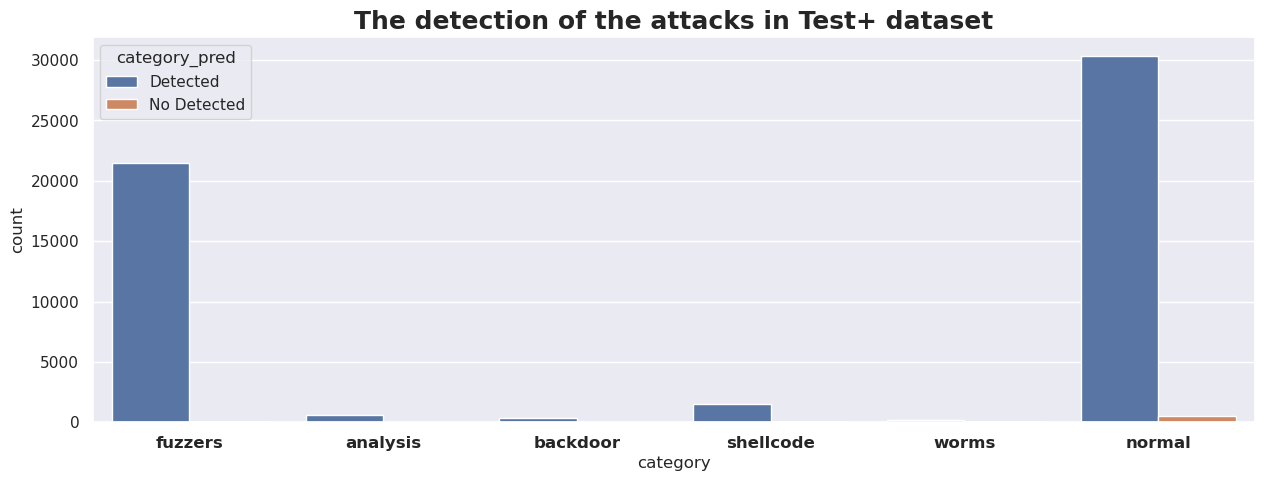

In [41]:
# Plotting target label distribution
plt.figure(figsize=(15,5))
sns.set_theme(style="darkgrid")
sns.countplot(x=data_plot['category'], data=data_plot, hue=data_plot['category_pred'])
plt.title('The detection of the attacks in Test+ dataset', weight='bold', fontsize='18')
plt.xticks(weight='bold', fontsize=12)
plt.show()

In [42]:
summary

,Traffic,Detected %,No Detected %,Detected Samples,No Detected Samples
0,Normal,98.396553,1.603447,30376,495
1,Analysis,100.000000,0.000000,622,0
2,Backdoor,100.000000,0.000000,357,0
3,Fuzzers,99.855928,0.144072,21486,31
4,Shellcode,99.933819,0.066181,1510,1
5,Worms,98.850575,1.149425,172,2


## UNSW-NB15-Train-Basic for training and UNSW-NB15-Test for validation

In [43]:
# Load UNSW-NB15-Test+
data = pd.read_csv('../datasets/UNSW-NB15-Test.csv', low_memory=False)

# Select the 'proto' and 'state' values that I want
data = data.loc[(data['proto'] == 'tcp') | (data['proto'] =='udp') | (data['proto'] =='icmp') | (data['proto'] =='arp') | (data['proto'] =='ipv6-icmp') | (data['proto'] =='igmp') | (data['proto'] =='rarp'), :]
data = data.loc[(data['state'] == 'RST') | (data['state'] =='REQ') | (data['state'] =='INT') | (data['state'] =='FIN') | (data['state'] =='CON') | (data['state'] =='ECO') | (data['state'] =='ACC') | (data['state'] =='PAR'), :]

# Extracting dataset labels
data_labels=data[['label']]

#Extracting dataset features
data_features=data[['proto','srcip','sport','dstip','dsport','spkts','dpkts','sbytes','dbytes','state','stime','ltime','dur']]

In [44]:
"""PREPROCESSING"""

# Preprocess IP and ports features
# IP Source Address
data_features['srcip'] = data_features['srcip'].apply(lambda x: x.split(".")[-1])
data_features['srcip'] = data_features['srcip'].apply(lambda x: x.split(":")[-1])
data_features['srcip'] = data_features['srcip'].apply(lambda x: int(x, 16))

# IP Destination Address
data_features['dstip'] = data_features['dstip'].apply(lambda x: x.split(".")[-1])
data_features['dstip'] = data_features['dstip'].apply(lambda x: x.split(":")[-1])
data_features['dstip'] = data_features['dstip'].apply(lambda x: int(x, 16))

# Ports
data_features['sport'] = data_features['sport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)
data_features['dsport'] = data_features['dsport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)

# Convert all ports with 0 decimal, and HEX to DEC
data_features['sport'] = data_features['sport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['sport'] = data_features['sport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

data_features['dsport'] = data_features['dsport'].replace('-', -1)
data_features['dsport'] = data_features['dsport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['dsport'] = data_features['dsport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

# Convert field to int format
data_features['srcip'] = data_features['srcip'].astype(int)
data_features['sport'] = data_features['sport'].astype(int)
data_features['dstip'] = data_features['dstip'].astype(int)
data_features['dsport'] = data_features['dsport'].astype(int)

# Convert some fields to logarithmic
log1p_col = ['dur', 'sbytes', 'dbytes', 'spkts']

for col in log1p_col:
    data_features[col] = data_features[col].apply(np.log1p)
    
# Create a complementary field of attack & Transform to One hot encoding - LABELS
normal=data_labels['label']
normal=normal.replace(1,2)
normal=normal.replace(0,1)
normal=normal.replace(2,0)

# Insert the new column in data labels
data_labels.insert(1, 'normal', normal)
data_labels = pd.get_dummies(data_labels)

# Transform to One hot encoding - FEATURES
data_features=pd.get_dummies(data_features)

# Normalize all data features
data_features = StandardScaler().fit_transform(data_features)

#Add dimension to data features
data_features = np.expand_dims(data_features, axis=2)
data_features = np.expand_dims(data_features, axis=3)

x_test, y_test=data_features, data_labels

In [45]:
x_test.shape

(602516, 24, 1, 1)

In [47]:
# Load Transfer Learning model
modelFE = load_model('../models/tmp/TransferLearning_Detection.keras')

/home/deeplearning01/anaconda3/envs/TL_IDS/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [48]:
#Evaluate the model
results = modelFE.evaluate(x_test, y_test, verbose=0)
print("test loss, test acc:", results)

test loss, test acc: [0.03569424897432327, 0.9915371537208557]


18829/18829 ━━━━━━━━━━━━━━━━━━━━ 7s 371us/step


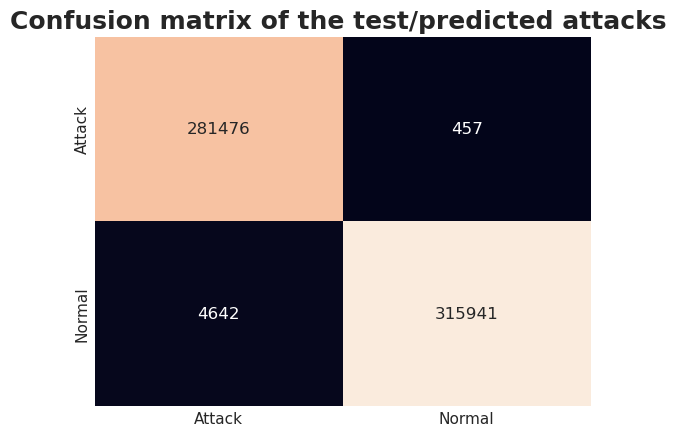

In [49]:
with tf.device('/GPU:0'):  # Use GPU 0    
    #  Prediction
    predicted = modelFE.predict(x_test)

    # Confusion matrix
    y_class = np.argmax(predicted, axis = 1)
    y_test1=y_test
    y_test1=y_test1.to_numpy()
    y_check = np.argmax(y_test1, axis = 1) 

    cmatrix = confusion_matrix(y_check, y_class)

    cmatrix_df = pd.DataFrame(cmatrix, index = ['Attack', 'Normal'], columns = ['Attack', 'Normal'])
    plt.title('Confusion matrix of the test/predicted attacks ', weight='bold', fontsize=18)
    plt.tick_params(length=0)
    plt.xlabel('Attacks')
    plt.ylabel('Predicted Attacks')
    sns.heatmap(cmatrix_df, annot=True, fmt="d", cbar=False)
    plt.show()

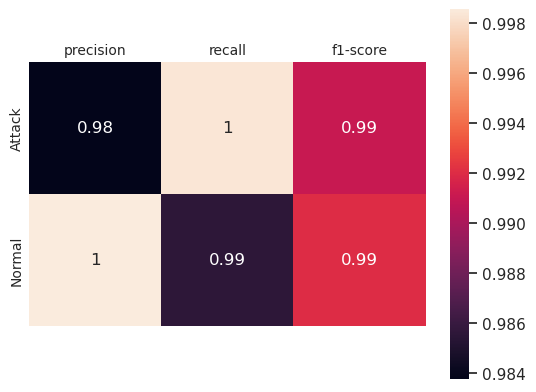

In [50]:
# Precision, Recall & F1-Score
class_rep = classification_report(y_check, y_class, target_names = ['Attack', 'Normal'], output_dict=True)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
plt.tick_params(length=0)
sns.heatmap(pd.DataFrame(class_rep).iloc[:-1, :-3].T, square=True, cbar=True, annot=True)
plt.show()

In [52]:
from sklearn import metrics

In [53]:
# Precision, Recall & F1-Score
FPR, TPR, THRESHOLD = metrics.roc_curve(y_check, y_class)

In [54]:
FPR[1]

0.001620952495805741

In [55]:
class_rep

{'Attack': {'precision': 0.983775924618514,
  'recall': 0.9983790475041943,
  'f1-score': 0.9910236932951443,
  'support': 281933.0},
 'Normal': {'precision': 0.9985556166600295,
  'recall': 0.9855201305122231,
  'f1-score': 0.9919950516577417,
  'support': 320583.0},
 'accuracy': 0.9915371542000544,
 'macro avg': {'precision': 0.9911657706392718,
  'recall': 0.9919495890082086,
  'f1-score': 0.991509372476443,
  'support': 602516.0},
 'weighted avg': {'precision': 0.9916398120733618,
  'recall': 0.9915371542000544,
  'f1-score': 0.9915405276662757,
  'support': 602516.0}}

## Analysing Attack Detection

### Code

In [56]:
predicted

array([[8.6709285e-01, 1.3290720e-01],
       [9.6773797e-01, 3.2262061e-02],
       [9.7995847e-01, 2.0041535e-02],
       ...,
       [5.1532366e-04, 9.9948466e-01],
       [5.3466734e-04, 9.9946529e-01],
       [1.8921627e-03, 9.9810779e-01]], dtype=float32)

In [57]:
df = pd.DataFrame(predicted)
df.index = data.index

In [58]:
df['attack']=data['label']
df['category']=data['attack_cat']
df['normal']=data_labels['normal']

In [59]:
df.columns = ['pred_attack', 'pred_normal', 'attack', 'category', 'normal']

In [60]:
dff=df
df=pd.get_dummies(df)
df=round(df)

In [61]:
analysis=df.loc[df['category_analysis'] == 1]
analysis=analysis[['pred_attack', 'pred_normal', 'attack', 'normal']]
analysis_pred=analysis[['pred_attack','pred_normal']]
analysis_check=analysis[['attack','normal']]

backdoor=df.loc[df['category_backdoor'] == 1]
backdoor=backdoor[['pred_attack', 'pred_normal', 'attack', 'normal']]
backdoor_pred=backdoor[['pred_attack','pred_normal']]
backdoor_check=backdoor[['attack','normal']]

fuzzers=df.loc[df['category_fuzzers'] == 1]
fuzzers=fuzzers[['pred_attack', 'pred_normal', 'attack', 'normal']]
fuzzers_pred=fuzzers[['pred_attack','pred_normal']]
fuzzers_check=fuzzers[['attack','normal']]

normal=df.loc[df['category_normal'] == 1]
normal=normal[['pred_attack', 'pred_normal', 'attack', 'normal']]
normal_pred=normal[['pred_attack','pred_normal']]
normal_check=normal[['attack','normal']]

shellcode=df.loc[df['category_shellcode'] == 1]
shellcode=shellcode[['pred_attack', 'pred_normal', 'attack', 'normal']]
shellcode_pred=shellcode[['pred_attack','pred_normal']]
shellcode_check=shellcode[['attack','normal']]

worms=df.loc[df['category_worms'] == 1]
worms=worms[['pred_attack', 'pred_normal', 'attack', 'normal']]
worms_pred=worms[['pred_attack','pred_normal']]
worms_check=worms[['attack','normal']]

generic=df.loc[df['category_generic'] == 1]
generic=generic[['pred_attack', 'pred_normal', 'attack', 'normal']]
generic_pred=generic[['pred_attack','pred_normal']]
generic_check=generic[['attack','normal']]

exploits=df.loc[df['category_exploits'] == 1]
exploits=exploits[['pred_attack', 'pred_normal', 'attack', 'normal']]
exploits_pred=exploits[['pred_attack','pred_normal']]
exploits_check=exploits[['attack','normal']]

reconnaissance=df.loc[df['category_reconnaissance'] == 1]
reconnaissance=reconnaissance[['pred_attack', 'pred_normal', 'attack', 'normal']]
reconnaissance_pred=reconnaissance[['pred_attack','pred_normal']]
reconnaissance_check=reconnaissance[['attack','normal']]

dos=df.loc[df['category_dos'] == 1]
dos=dos[['pred_attack', 'pred_normal', 'attack', 'normal']]
dos_pred=dos[['pred_attack','pred_normal']]
dos_check=dos[['attack','normal']]

In [62]:
#Correctly detected
countdata=pd.DataFrame()
normal_c = normal['pred_normal'] * normal['normal']
analysis_c = analysis['pred_attack'] * analysis['attack']
backdoor_c = backdoor['pred_attack'] * backdoor['attack']
fuzzers_c = fuzzers['pred_attack'] * fuzzers['attack']
shellcode_c = shellcode['pred_attack'] * shellcode['attack']
worms_c = worms['pred_attack'] * worms['attack']
generic_c = generic['pred_attack'] * generic['attack']
exploits_c = exploits['pred_attack'] * exploits['attack']
reconnaissance_c = reconnaissance['pred_attack'] * reconnaissance['attack']
dos_c = dos['pred_attack'] * dos['attack']

In [63]:
# Count 0 and 1
normal_c0 = (normal_c == 0).sum()
normal_c1 = len(normal) - normal_c0

analysis_c0 = (analysis_c == 0).sum()
analysis_c1 = len(analysis) - analysis_c0

backdoor_c0 = (backdoor_c == 0).sum()
backdoor_c1 = len(backdoor) - backdoor_c0

fuzzers_c0 = (fuzzers_c == 0).sum()
fuzzers_c1 = len(fuzzers) - fuzzers_c0

shellcode_c0 = (shellcode_c == 0).sum()
shellcode_c1 = len(shellcode) - shellcode_c0

worms_c0 = (worms_c == 0).sum()
worms_c1 = len(worms) - worms_c0

generic_c0 = (generic_c == 0).sum()
generic_c1 = len(generic) - generic_c0

exploits_c0 = (exploits_c == 0).sum()
exploits_c1 = len(exploits) - exploits_c0

reconnaissance_c0 = (reconnaissance_c == 0).sum()
reconnaissance_c1 = len(reconnaissance) - reconnaissance_c0

dos_c0 = (dos_c == 0).sum()
dos_c1 = len(dos) - dos_c0

In [64]:
normal_0, normal_1 = normal_c0*100 / len(normal), normal_c1*100 / len(normal)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(normal_0, normal_1))

There are 1.45 % of NO detected and 98.55 % of detected samples


In [65]:
analysis_0, analysis_1 = analysis_c0*100 / len(analysis), analysis_c1*100 / len(analysis)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(analysis_0, analysis_1))

There are 0.16 % of NO detected and 99.84 % of detected samples


In [66]:
backdoor_0, backdoor_1 = backdoor_c0*100 / len(backdoor), backdoor_c1*100 / len(backdoor)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(backdoor_0, backdoor_1))

There are 1.12 % of NO detected and 98.88 % of detected samples


In [67]:
fuzzers_0, fuzzers_1 = fuzzers_c0*100 / len(fuzzers), fuzzers_c1*100 / len(fuzzers)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(fuzzers_0, fuzzers_1))

There are 1.19 % of NO detected and 98.81 % of detected samples


In [68]:
shellcode_0, shellcode_1 = shellcode_c0*100 / len(shellcode), shellcode_c1*100 / len(shellcode)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(shellcode_0, shellcode_1))

There are 0.13 % of NO detected and 99.87 % of detected samples


In [69]:
worms_0, worms_1 = worms_c0*100 / len(worms), worms_c1*100 / len(worms)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(worms_0, worms_1))

There are 1.15 % of NO detected and 98.85 % of detected samples


In [70]:
generic_0, generic_1 = generic_c0*100 / len(generic), generic_c1*100 / len(generic)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(generic_0, generic_1))

There are 0.02 % of NO detected and 99.98 % of detected samples


In [71]:
exploits_0, exploits_1 = exploits_c0*100 / len(exploits), exploits_c1*100 / len(exploits)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(exploits_0, exploits_1))

There are 0.41 % of NO detected and 99.59 % of detected samples


In [72]:
reconnaissance_0, reconnaissance_1 = reconnaissance_c0*100 / len(reconnaissance), reconnaissance_c1*100 / len(reconnaissance)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(reconnaissance_0, reconnaissance_1))

There are 0.05 % of NO detected and 99.95 % of detected samples


In [73]:
dos_0, dos_1 = dos_c0*100 / len(dos), dos_c1*100 / len(dos)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(dos_0, dos_1))

There are 0.75 % of NO detected and 99.25 % of detected samples


In [74]:
summary = pd.DataFrame({"Traffic":
                   ["Normal", "Analysis", "Backdoor", "Fuzzers", "Shellcode", "Worms", "Generic", "Exploits", "Reconnaissance", "DoS"],
                   "Detected %": [normal_1, analysis_1, backdoor_1, fuzzers_1, shellcode_1, worms_1, generic_1, exploits_1, reconnaissance_1, dos_1],
                   "No Detected %": [normal_0, analysis_0, backdoor_0, fuzzers_0, shellcode_0, worms_0, generic_0, exploits_0, reconnaissance_0, dos_0],
                   "Detected Samples": [normal_c1, analysis_c1, backdoor_c1, fuzzers_c1, shellcode_c1, worms_c1, generic_c1, exploits_c1, reconnaissance_c1, dos_c1],
                   "No Detected Samples": [normal_c0, analysis_c0, backdoor_c0, fuzzers_c0, shellcode_c0, worms_c0, generic_c0, exploits_c0, reconnaissance_c0, dos_c0]})

In [75]:
dff['category_pred'] = np.where(((df['attack'] == 1) & (df['pred_attack'] == 1)) | ((df['normal'] == 1) & (df['pred_normal'] == 1)), 'Detected', 'No Detected')

In [76]:
data_plot=dff[['category', 'category_pred']]

In [77]:
data_plot

,category,category_pred
0,exploits,Detected
1,exploits,Detected
2,reconnaissance,Detected
3,exploits,Detected
4,exploits,Detected
...,...,...
642561,normal,Detected
642562,normal,Detected
642563,normal,Detected
642564,normal,Detected


### Results

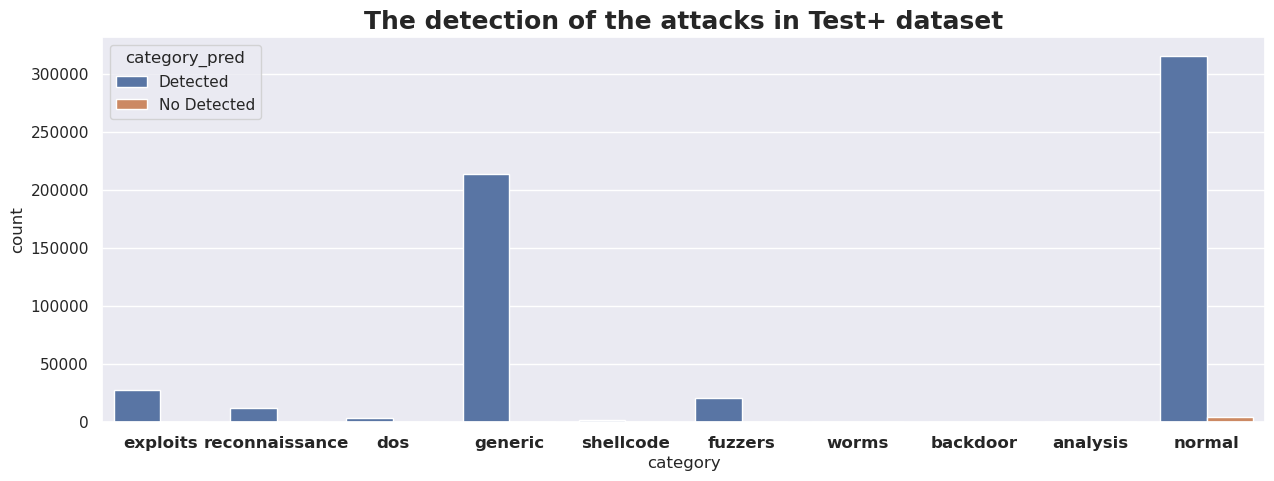

In [78]:
# Plotting target label distribution
plt.figure(figsize=(15,5))
sns.set_theme(style="darkgrid")
sns.countplot(x=data_plot['category'], data=data_plot, hue=data_plot['category_pred'])
plt.title('The detection of the attacks in Test+ dataset', weight='bold', fontsize='18')
plt.xticks(weight='bold', fontsize=12)
plt.show()

In [79]:
summary

,Traffic,Detected %,No Detected %,Detected Samples,No Detected Samples
0,Normal,98.552013,1.447987,315941,4642
1,Analysis,99.839228,0.160772,621,1
2,Backdoor,98.879552,1.120448,353,4
3,Fuzzers,98.814891,1.185109,21262,255
4,Shellcode,99.867637,0.132363,1509,2
5,Worms,98.850575,1.149425,172,2
6,Generic,99.980348,0.019652,213676,42
7,Exploits,99.590352,0.409648,28201,116
8,Reconnaissance,99.949384,0.050616,11848,6
9,DoS,99.249288,0.750712,3834,29
